# Image and equation solving 

EDA notebook to inspect the images to be fed to the model.
And to find out how I can make openCV's findcontours combine contours of individual traces that should be read as a single symbol

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [1485]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

#tensorflow
from tensorflow.keras.preprocessing.image import img_to_array, load_img

First of all, how images of individual symbols do we have?

In [15]:
label_dirs = glob.glob('../processed_images/*')

What symbols are on the images, and how many in each class?

In [20]:
label_dic = {}
for label_dir in label_dirs:
    label = label_dir.split('label_')[-1]
    label_imgs = glob.glob(label_dir + '/*png')
    label_dic[label] = len(label_imgs)

In [21]:
len(label_dic)

100

What is their distribution?

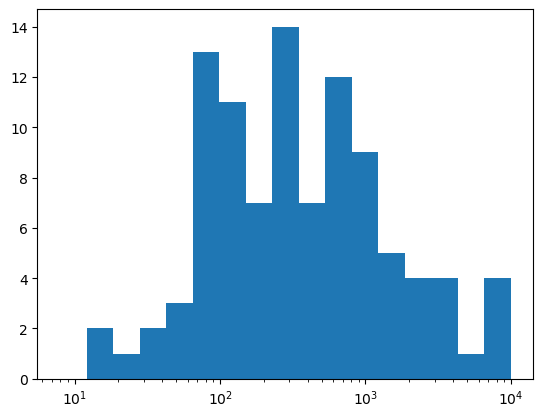

In [39]:
logbins = np.logspace(0.9, 4, 18)

plt.hist(label_dic.values(), bins=logbins)
plt.xscale('log')
plt.show()

And the cumulative distribution

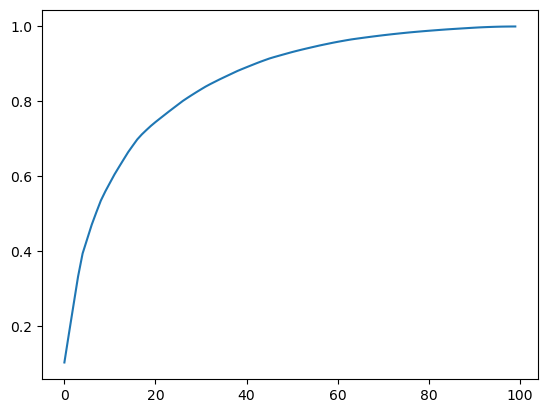

In [206]:
s_v = sorted(label_dic.values())[::-1]
s_cumu = np.cumsum(s_v)/sum(label_dic.values())

plt.plot(s_cumu)
plt.show()

## Equation solving EDA

I want to see how well openCV findcontours can actually read single symbols. One of the most obvious issues would be the 'equals', and 'greater or equal /lesser or equal than' signs. Those will always be read as two individual contours, given that they are separated from each other by some distance

In [219]:
eq_labels = ['=',  '\leq', '\geq']
eq_imgs = []
for label in eq_labels:
    eq_imgs += glob.glob('../processed_images/label_' + label + '/*')

Plot how much these boxes typically overlap for equal signs

In [220]:
def calc_box_overlap(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    r_l = [[],[]]
    for i,c in enumerate(cnt[1:3]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        r_l[1].append(x2+x1)
        r_l[0].append(x1)
    
    
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    try:
        return overlap/totl
    except:
        return 0

In [221]:
ol = []
for img_file in eq_imgs:
    ol.append(calc_box_overlap(img_file))

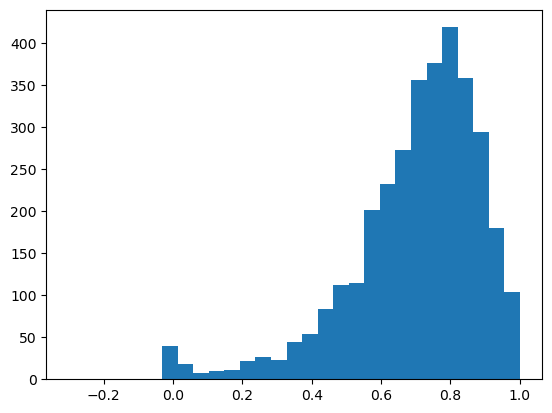

In [222]:
linbins = np.linspace(-0.3, 1, 30)
plt.hist(ol, bins=linbins);

In [223]:
ol_arr = np.array(ol)
bo = np.where(ol_arr < 0.25)[0]
print(f'Fraction of equal signs with less than 25% overlap: {len(bo)/len(ol)}')

Fraction of equal signs with less than 25% overlap: 0.03419565863812073


Based on this, I  might be able to make some inferences about when two boxes are likely to belong together or not

197 72 178 262
225 232 233 182


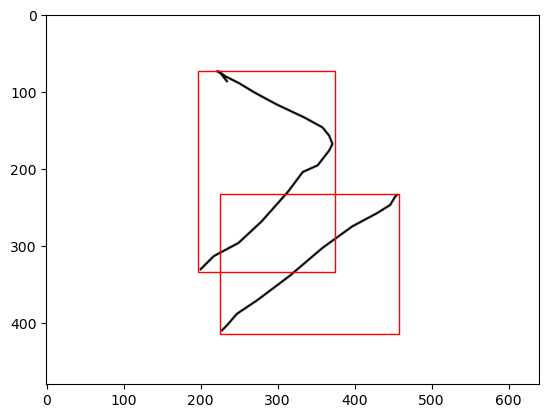

In [359]:
img = cv2.imread(eq_imgs[-1],cv2.IMREAD_GRAYSCALE)

ret,thresh=cv2.threshold(img, 230,255,cv2.THRESH_BINARY)
ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

r_l = [[],[]]
for i,c in enumerate(cnt[1:]):
    x1,y1,x2,y2= cv2.boundingRect(c)
    print(x1,y1, x2, y2)

    rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

How well can findContours do in general?

In [225]:
full_eq_imgs = glob.glob('../full_eq_imgs/*png')

In [1892]:
def resolve_symbols_on_img_test(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return

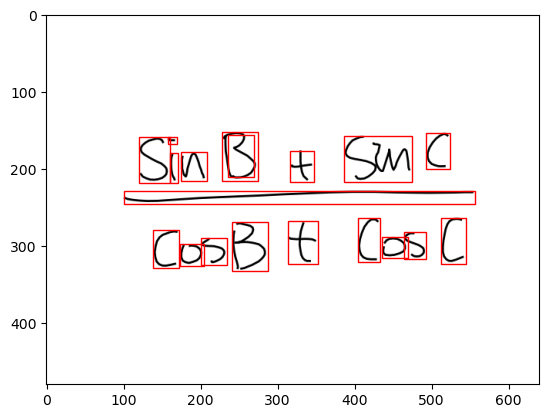

In [1893]:
resolve_symbols_on_img_test(full_eq_imgs[20])

There are some issues with this that I'll need to figure out
1) if one box is  completely inside another box, I want to get rid of it because it's likely to be an inner contour. However if there are many boxes inside a box (like under a root) then they should remain
2) if two boxes are close to each other and are likely to form an equals or plusminus or leq/geq sign, turn them into one box
3) Find out which order the symbols need to be put in the equation, and which symbols belong together on the same level (like in a fraction)
4) Once i have the order, find out if a subsequent symbol is likely to be a subscript or superscript of the previous one

### 1) Removing a box inside another box

In [2702]:
def box_inside_box(coords1, coords2):
    """
    returns True if the second box is inside the first box
    coords are in the form [x1, y1, x2, y2]
    """
    
    if (coords2[1] >= coords1[1]) and (coords2[3] <= coords1[3]) and (coords2[0] >= coords1[0]) and (coords2[2] <= coords1[2]):
        return True
    else:
        return False
    
def remove_box_inside_box(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2]
    Check if any boxes are completely inside another box. 
    If there are fewer than 3 boxes inside another box (eg. its not a root with lots of stuff in it)
    Assume these are wrong and remove them
    """
    pop_boxes = []
    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox]
        isInside = False
        eq_i = 0 #counter to keep track of how many boxes are inside other boxes
        
        boxes_to_pop = []
        for j,ebox in enumerate(ebox_list):
            #check how many boxes are inside this box
            if box_inside_box(box, ebox) == True:
                isInside = True
                eq_i += 1
                boxes_to_pop.append(ebox)
        
        #add all the boxes to the to pop list
        if (isInside == True) and (eq_i <= 3):
            pop_boxes.extend(boxes_to_pop)

    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass
    return box_list

### 2) merging boxes that might need to be merged

In [2703]:
def has_overlap(coords1, coords2):
    """
    check if first box overlaps at least 25% with the second box in x-coordinates
    """
    r_l = [[],[]]
    for i in range(2):
        r_l[i].extend([coords1[i*2], coords2[i*2]])
    
    #the total x-space extended by the two boxes
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    
    xlen_b1 = coords1[2] - coords1[0]
    xlen_b2 = coords2[2] - coords2[0]
    lenlist = [xlen_b1, xlen_b2]
    
    #if one box extends beyond the other on both sides, the overlap should just be 1
    if max([xlen_b1, xlen_b2]) == totl:
        overlap = totl

    if overlap/totl > 0.25:
        return True
    else:
        return False

def merge_boxes(coords1, coords2):
    """
    Take two boxes with coords [x1, y1, x2, y2]
    and merge them into a box spanning both
    """
    new_x1 = min(coords1[0], coords2[0])
    new_y1 = min(coords1[1], coords2[1])
    new_x2 = max(coords1[2], coords2[2])
    new_y2 = max(coords1[3], coords2[3])
    
    return new_x1, new_y1, new_x2, new_y2

In [2704]:
def infer_boxes_to_merge(boxl):
    """
    For a list of boxes that are overlapping in x-coordinates, check which box is the closest in distance either above or below the box
    If a box on either side matches certain criteria about the x and ylengths, assume it's two components of an equals sign or ! or i, etc.
    And return the coordinates of the two boxes that should be merged
    """
    
    box_0 = boxl[0]
    y_c0 = (box_0[3] + box_0[1])/2
    
    #find two closest vertical boxes on either side (above, and below)
    ydist_min, ydist_max = 1000, 1000
    box_i_min, box_i_max = 0, 0
    for i,box in enumerate(boxl[1:]):
        yb = (box[3] + box[1])/2
        
        ydist = yb - y_c0
        print(ydist)

        if ydist < 0:
            if abs(ydist) < ydist_min:
                ydist_min = abs(ydist)
                box_i_min = i+1
        elif ydist >= 0:
            if ydist < ydist_max:
                ydist_max = ydist
                box_i_max = i+1

    #these are the two closest boxes above and below the box
    cbox_down = boxl[box_i_min]
    cbox_up = boxl[box_i_max]
    
    #get lengths in x-coordinates for the box and the two closest boxes
    xlen_box = box_0[2] - box_0[0]
    xlen_cbox_up = cbox_up[2] - cbox_up[0]
    xlen_cbox_down = cbox_down[2] - cbox_down[0]
    
    xlens_up = [xlen_box, xlen_cbox_up]
    xlens_down = [xlen_box, xlen_cbox_down]
    
    #also check if the one of the boxes it not much longer vertically than the other one
    ylen_box = box_0[3] - box_0[1]
    ylen_cbox_up = cbox_up[3] - cbox_up[1]
    ylen_cbox_down = cbox_down[3] - cbox_down[1]
    
    ylens_up = [ylen_box, ylen_cbox_up]
    ylens_down = [ylen_box, ylen_cbox_down]
    
    #if 1) one of the boxes is not more than 1.8 as long (in x-coords) as the other one
    # AND 2) the y-length of one box is not more than 4x that of the other one AND 5x the ylength of the smallest box is larger than the y-distance between the boxes
    # AND 3) the closest box is not the box itself
    # then assume that the boxes should be merged
    
    is_ol_up = max(xlens_up) < 1.7*min(xlens_up) and   \
            (max(ylens_up) < 5*min(ylens_up) and 5*min(ylens_up) > ydist_max) \
            and cbox_up != box_0
    
    is_ol_down = max(xlens_down) < 1.7*min(xlens_down) and \
            (max(ylens_down) < 5*min(ylens_down) and 5*min(ylens_down) > ydist_min ) \
            and cbox_down != box_0

    #print(xlens_up, ylens_up, ydist_max)
    #print(xlens_down, ylens_down, ydist_min)
    print(max(xlens_up) < 1.7*min(xlens_up), max(ylens_up) < 5*min(ylens_up), 5*min(ylens_up) > ydist_max, cbox_up != box_0)
    print(max(xlens_down) < 1.7*min(xlens_down), (max(ylens_down) < 5*min(ylens_down)), 5*min(ylens_down) > ydist_min, cbox_down != box_0)
    print(is_ol_up, is_ol_down)
    if is_ol_up == True:
        return [box_0, cbox_up]
    elif is_ol_down == True:
        return [box_0, cbox_down]
    else:
        return [box_0]

In [2705]:
def create_merged_boxes(box_list):
    
    #now check if any boxes overlap with each other in x coordinates
    tot_overlap_boxes = []
    merged_box_list = []

    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox] 
        eq_b = 0
        overlap_boxes = [box]
        for j,ebox in enumerate(ebox_list):
            if has_overlap(box, ebox) == True:
                overlap_boxes.append(ebox)
    
        tot_overlap_boxes.append(overlap_boxes)
        
    pop_boxes = []
    
    #find which of the overlapping boxes might fit the criteria to be merged
    for i in range(len(tot_overlap_boxes)):
        if len(tot_overlap_boxes[i]) > 1:
            boxes_to_merge = infer_boxes_to_merge(tot_overlap_boxes[i])
            if len(boxes_to_merge) == 2:
                print('merge boxes:', boxes_to_merge)
                #if a pair of boxes to be merged is found, merge them and add the individual boxes to the remove list
                merged_box_list.append(merge_boxes(*boxes_to_merge))
                pop_boxes.extend(boxes_to_merge)
    print('box_list', box_list)
    #remove all the boxes that were merged
    print('removing these boxes:',pop_boxes)
    print('merged boxes:', merged_box_list)
    #remove all the boxes that were merged
    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass
    return box_list, merged_box_list

### 3) Figure out the order of each symbol

In [2706]:
#i'll need these functins to figure out whether a symbol is part of a stack (levels on top of each other) or not
def has_overlap_x(coords1, coords2):
    """
    check if the smaller of the two boxes is at least 50% covered by the larger box in x-length
    """
    r_l = [[],[]]
    for i in range(2):
        r_l[i].extend([coords1[i*2], coords2[i*2]])
    
    #the total x-space extended by the two boxes
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    
    xlen_b1 = coords1[2] - coords1[0]
    xlen_b2 = coords2[2] - coords2[0]
    lenlist = [xlen_b1, xlen_b2]

    #sort boxes by xlen
    sort_boxes = [box for (_, box) in sorted(zip(lenlist, [coords1, coords2]))]
    #print(sort_boxes)
    #the smaller box is now sort_boxes[0]
    isoverlap = False
    if max(lenlist) == totl:
        isoverlap = True
    #case where the smaller box extends left
    if (sort_boxes[0][0] < sort_boxes[1][0]) and (sort_boxes[0][2] - sort_boxes[1][0]) > 0.2*min(lenlist):
        isoverlap = True
    #case where the smaller box extends right
    if (sort_boxes[0][2] > sort_boxes[1][2]) and (sort_boxes[1][2] - sort_boxes[0][0]) > 0.2*min(lenlist):
        isoverlap = True
    return isoverlap

def has_overlap_y(coords1, coords2):
    """
    check if first box is fully above or below the second box
    """
    r_l = [[],[]]
    for i in range(2):
        r_l[i].extend([coords1[1+i*2], coords2[1+i*2]])
    
    #the total y-space extended by the two boxes
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    
    ylen_b1 = coords1[2] - coords1[0]
    ylen_b2 = coords2[2] - coords2[0]
    lenlist = [ylen_b1, ylen_b2]
    
    #if one box extends beyond the other on both sides, the overlap should just be 1
    if max(lenlist) == totl:
        overlap = totl

    if overlap/totl > 0.10:
        return True
    else:
        return False


In [2707]:
#if a symbol is in a stack, figure out its location relative to the other boxes
def above_below_box(box, overlap_boxlist):
    """
    Given a box and the list of overlapping boxes, check if the overlapping boxes are above or below
    (or both) the box
    """
    ymin_0 = box[1]
    ymins = np.array([overlap_boxlist[j][1] for j in range(len(overlap_boxlist))])
    
    hasBelow = False
    hasAbove = False
    for ymin in ymins:
        if ymin > ymin_0:
            hasBelow = True
        if ymin < ymin_0:
            hasAbove = True
    if hasBelow == True and hasAbove == True:
        return 1
    elif hasBelow == True:
        return 0
    elif hasAbove == True:
        return 2

In [2708]:
def infer_box_level(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2],
    Find out which 'level' of the equation the box is in
    """

    #figure out levels
    #first sort all the boxes by their x1 coordinate
    
    xmins_l = np.array([box_list[j][0] for j in range(len(box_list))])
    s_box_list = [box for (_, box) in sorted(zip(xmins_l, box_list))]

    #first, for each box obtain a list of the boxes this box overlaps with, matching certain criteria
    overlap_list = []
    for b, box in enumerate(s_box_list):
        
        #list of all the boxes to check against
        ebox_list = [ebox for ebox in s_box_list if box != ebox] 
        overlap_boxes = []
        overlap_labels = []

        for j,ebox in enumerate(ebox_list):
            if (has_overlap_x(box, ebox) == True) and (has_overlap_y(box,ebox) == False):
                overlap_boxes.append(ebox)
                overlap_labels.append(s_box_list.index(ebox))
        overlap_list.append(overlap_boxes)
    
    #now I have the list for each box that this box overlaps with, and I can infer the levels
    level = 0
    level_list = []
    stacked_level_list = [] #to keep track of whether the level is part of a stack or not
    in_levels= False
    enter_levels = False
    for b, box in enumerate(s_box_list):
        
        #check if a box shares a single overlap with another box. in that case, don't count it as a stack cause its likely to be a super/subscript
        if len(overlap_list[b]) > 0:
            #the index of the box that this box overlaps with
            ol_idx = s_box_list.index(overlap_list[b][0])
            #if both overlap lists have length 1 (it implies their overlapping box is each other) 
            if len(overlap_list[b]) == 1 and len(overlap_list[ol_idx]) == 1:
                single_overlap = True
            else:
                single_overlap = False
        else:
            single_overlap = False
        
        #check if box has overlapping boxes that is not a single overlap
        if len(overlap_list[b]) > 0 and single_overlap == False:
            #if we were in an unleveled part and we are entering a fraction, add a level
            if enter_levels == True:
                level += 1
                enter_levels = False
            #are there boxes both above and below this box?
            #0 = below
            #1 = both
            #2 = above
            level_add = above_below_box(box, overlap_list[b])
            level_list.append(level + level_add)
            stacked_level_list.append(True)
            in_levels = True
        else:
            #if we were in a level previously but not anymore, add 1 to indicate we are in a new level
            if in_levels == True: 
                level +=3 
            in_levels = False
            enter_levels = True
            #if there are no overlapping boxes, we can set the level to the same as the previous level and move on
            level_list.append(level)
            stacked_level_list.append(False)
            
    #finally, sort the boxes by level
    s_box_list = [box for (_, box) in sorted(zip(level_list, s_box_list))]
    s_stacked_level_list = [isstack for (_, isstack) in sorted(zip(level_list, stacked_level_list))]
    s_level_list = sorted(level_list)
    
    #return 1) the list of boxes, sorted by level and xmin coords
    #2) the list of levels (sorted)
    #3) a boolean list, which for each box shows if its part of a stack or not
    return s_box_list, s_level_list, s_stacked_level_list

### 4) Figure out whether each subsequent symbol is a super/subscript of the previous symbol

In [2709]:
def sub_or_superscript_level(coords1, level1, coords2, level2):
    """
    Given two boxes and their levels, determine whether the second box is a subscript or superscript of the first box
    """
    # if the symbols are not the same level, return -10
    if level1 != level2:
        return -10  
    
    ylen_b1 = coords1[3] - coords1[1]
    ylen_b2 = coords2[3] - coords2[1]
    
    #if the ymin of box2 is higher than the ymax of box1, its a subscript (and superscript if the ymax is lower)
    if coords2[1] > coords1[3]:
        return -1
    if coords2[3] < coords1[1]:
        return 1
    
    # if the second box extends both higher and lower, it's not a super/subscript
    if (coords2[3] > coords1[3]) and (coords2[1] < coords1[1]):
        return 0
    
    #if 40% of the second box extends above/below the first box and doesn't extend too close to the other side of the first box, assume it's a super/subscrpt
    if (coords2[3] - coords1[3] > 0.5*ylen_b2) and coords2[1] - coords1[1] > 0.2*ylen_b1 :
        return -1
    elif (coords1[1] - coords2[1] > 0.5*ylen_b2) and coords1[3]-coords2[3] > 0.2*ylen_b1:
        return 1
    
    #if 10% of the second box extends above/below and the ylen is 60% or smaller also assume it's a super/subscript
    if coords2[3] - coords1[3] > 0.1*ylen_b2 and ylen_b2 < 0.6*ylen_b1:
        return -1
    elif coords1[1] - coords2[1] > 0.1*ylen_b2 and ylen_b2 < 0.6*ylen_b1:
        return 1
    
    #if the second box is 40% the length of the first box and the box doesnt cover the the y the center of hte first box
    #assume it's a super/subscript based on whether the ycenter is lower or higher
    if (ylen_b2 < 0.4*ylen_b1):
        if (coords1[3] + coords1[1]) * 0.5 >= (coords2[3] + coords2[1])*0.5 and ((coords1[3] + coords1[1]) * 0.5 + 0.1*ylen_b1) > coords2[3]:
            return 1
        if (coords1[3] + coords1[1]) * 0.5 < (coords2[3] + coords2[1]) * 0.5 and ((coords1[3] + coords1[1]) * 0.5 + 0.1*ylen_b1) < coords2[1]:
            return -1
    
    #if none of these conditios are satisfied, assume the box is not a super or subscript
    return 0
    

In [2710]:
def sub_or_superscript_level_2(coords1, level1, coords2, level2):
    """
    Given two boxes and their levels, determine whether the second box is a subscript or superscript of the first box
    """
    # if the symbols are not the same level, return -10
    if level1 != level2:
        return -10, 0
    
    ylen_b1 = coords1[3] - coords1[1]
    ylen_b2 = coords2[3] - coords2[1]
    
    #calculate the 'superscript score': 
    #1) 1 - ylen_ratio
    s1 = 1 - ylen_b2/ylen_b1
    
    s2 = 0
    #2) how much does the box stick out?
    if (coords2[3] > coords1[3]) and (coords2[1] < coords1[1]):
        #box sticks out more at the bottom
        if coords2[3] - coords1[3] > coords1[1] - coords2[1]:
            s2 = coords2[3] - coords1[3]
        else:
            s2 = coords1[1] - coords2[1]
    if (coords2[3] > coords1[3]) > 0:
        s2 = coords2[3] - coords1[3]
    if (coords1[1] - coords2[1]) > 0:
        s2 = coords1[1] - coords2[1]
    s2 = s2/ylen_b2 * 2.8
    tot_score = s1 + s2
    
    #check if it's a subscript or superscript
    yc_1 = (coords1[1] + coords1[3]) * 0.5 
    yc_2 =  (coords2[1] + coords2[3]) * 0.5 
    if tot_score > 1 and yc_1 > yc_2:
        return 1, tot_score
    elif tot_score > 1 and yc_1 < yc_2:
        return -1, tot_score
    else:
        return 0, tot_score

### Putting it all together

In [2711]:
def resolve_symbols_on_img(img_file):
    
    #find contours
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])
    fig, ax = plt.subplots()
    #bkg_img = np.ones(img.shape)*255
    #bkg_img[0,0] = 0
    ax.imshow(img, cmap='gray')

    box_list = []
    
    #get the bounding boxes for all contours
    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        x2 += x1
        y2 += y1
        
        box_list.append([x1, y1, x2, y2])
    
    #step 1) remove boxes that are inside another box under certain criteria
    box_list = remove_box_inside_box(box_list)
    
    #step 2) find which boxes should be merged, and remove the individual boxes
    box_list, merged_box_list = create_merged_boxes(box_list)
    
    #remove non-unique boxes (there might be duplicates in the merged box list)
    tot_boxes = box_list + merged_box_list
    tot_boxes = [list(x) for x in set(tuple(x) for x in tot_boxes)]

    print('tot boxes', tot_boxes)
    #step 3) of all the boxes that are left, infer the order
    tot_boxes, box_levels, stacked_list = infer_box_level(tot_boxes)

    #step 4) figuring out the 'script level' of each symbol (whetehr it's on the line, or sub/superscript)
    script_level = 0 
    script_level_list = [0]
    for b, box in enumerate(tot_boxes[:-1]):
        script_add = sub_or_superscript_level(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        script_add, score = sub_or_superscript_level_2(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        if script_add == -10:
            script_level = 0
        else:
            script_level += script_add
        script_level_list.append(script_level)
    #print('script level list', script_level_list)
    #print('symbol level list', box_levels)
    colors = ['r', 'g', 'b', 'g']
    
    #make a list for the individual symbols
    ind_symbols = []
    for i, box in enumerate(tot_boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2] - box[0]
        y2 = box[3] - box[1]
   
        if stacked_list[i] == True:
            er = 'b'
        else:
            er = 'r'
            
        if script_level_list[i] != 0:
            er = 'g'
            
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor=er, facecolor='none')

        ax.add_patch(rect)
        ax.text(x1, y1, str(i))
        ind_symbols.append(img[y1:y1+y2,x1:x1+x2])

    return ind_symbols, box_levels, script_level_list

34.0
True True True True
True True False False
True False
merge boxes: [[240, 190, 300, 202], [239, 224, 286, 236]]
-34.0
True True False False
True True True True
False True
merge boxes: [[239, 224, 286, 236], [240, 190, 300, 202]]
51.0
148.0
True True True True
True True False False
True False
merge boxes: [[444, 139, 508, 212], [458, 219, 556, 234]]
-51.0
97.0
True True False True
True True True True
False True
merge boxes: [[458, 219, 556, 234], [444, 139, 508, 212]]
-148.0
-97.0
True True False False
True True False True
False False
box_list [[100, 183, 177, 314], [240, 190, 300, 202], [239, 224, 286, 236], [444, 139, 508, 212], [458, 219, 556, 234], [442, 301, 517, 346]]
removing these boxes: [[240, 190, 300, 202], [239, 224, 286, 236], [239, 224, 286, 236], [240, 190, 300, 202], [444, 139, 508, 212], [458, 219, 556, 234], [458, 219, 556, 234], [444, 139, 508, 212]]
merged boxes: [(239, 190, 300, 236), (239, 190, 300, 236), (444, 139, 556, 234), (444, 139, 556, 234)]
tot boxes [[

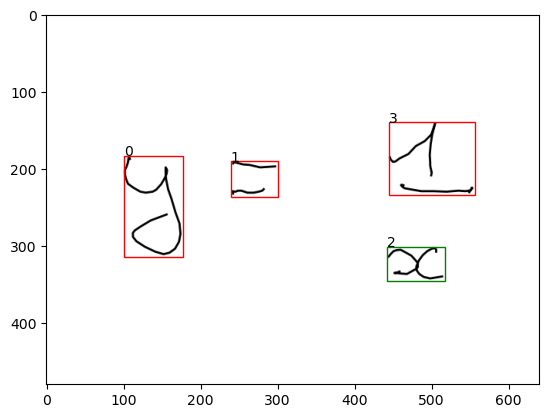

In [2712]:
symbs, levels, script_levels = resolve_symbols_on_img(full_eq_imgs[12])


I will put all of the above in a .py file equation_solving.py, so that I can call on the functions in another notebook

In [2735]:
class BoxPositions:
    """
    Class that can compare the relative positions of two boxes
    """
    def __init__(self, coords1, coords2):
        self.coords1 = coords1
        self.coords2 = coords2
        
        #calc properties that I might need
        self.x1s = [coords1[0], coords2[0]]
        self.y1s = [coords1[1], coords2[1]]
        self.x2s = [coords1[2], coords2[2]]
        self.y2s = [coords1[3], coords2[3]]
        
        #lengths
        self.xlen_b1 = self.x2s[0] - self.x1s[0]
        self.ylen_b1 = self.y2s[0] - self.y1s[0]
        
        self.xlen_b2 = self.x2s[1] - self.x1s[1]
        self.ylen_b2 = self.y2s[1] - self.y1s[1]
        
        self.xlens  = [self.xlen_b1, self.xlen_b2]
        self.ylens = [self.ylen_b1, self.ylen_b2]
        
        #centers
        self.xcs = [self.x2s[0]*0.5 + self.x1s[0]*0.5, self.x2s[1]*0.5 + self.x1s[1]*0.5]
        self.ycs = [self.y2s[0]*0.5 + self.y1s[0]*0.5, self.y2s[1]*0.5 + self.y1s[1]*0.5]
           
        #ydist
        self.ydist = self.ycs[1] - self.ycs[0]
    
    def isSame(self):
        """
        Check whether the boxes are the same
        """
        if self.coords1 == self.coords2:
            return True
        else:
            return False
        
    def isInside(self):
        """
        Check whether the second box is completley inside the first box
        """
        if (self.y1s[1] >= self.y1s[0]) and (self.y2s[1] <= self.y2s[0]) and (self.x1s[1] >= self.x1s[0]) and (self.x2s[0] > self.x2s[1]):
            return True
        else:
            return False
        
    def isBigger(self, len_factor, axis='x'):
        """
        Check whether the bigger box is NOT bigger than the smaller box by some specified factor on the specified axis
        """
        if axis == 'x':
            if max(self.xlens) < min(self.xlens) * len_factor:
                return True
            else:
                return False
        if axis == 'y':
            if max(self.ylens) < min(self.ylens) * len_factor:
                return True
            else:
                return False
            
    def calc_Overlap(self, axis='x', relative_to='both'):
        """
        Check how much overlap the box has along the specified axis
        """
        ext_left= self.boxExtends(direction='left')
        ext_right= self.boxExtends(direction='right')
        ext_top= self.boxExtends(direction='top')
        ext_bottom= self.boxExtends(direction='bottom')

        if axis == 'x':
            #if one of the boxes is longer than the other on both sides, the overlap should be 1
            if (ext_left and ext_right) or (not ext_left and not ext_right):
                overlap = 1
            else:
                abs_overlap = min(self.x2s) - max(self.x1s)
                if relative_to == 'both': #the overlap wrt to the full distance spanned by both boxes
                    totl = max(self.x2s) - min(self.x1s)
                elif relative_to == 'smaller': #how much of the smaller box overlaps with the bigger box
                    totl = min(self.xlens)
                overlap = abs_overlap/totl
                
        if axis == 'y':
            if (ext_top and ext_bottom) or (not ext_top and not ext_bottom):
                overlap = 1
            else:
                abs_overlap = min(self.y2s) - max(self.y1s)
                if relative_to == 'both': #the overlap wrt to the full distance spanned by both boxes
                    totl = max(self.y2s) - min(self.y1s)
                elif relative_to == 'smaller': #how much of the smaller box overlaps with the bigger box
                    totl = min(self.ylens)
                overlap = abs_overlap/totl
        return overlap
    
    def calc_box_extends(self):
        """
        Calculate how much box 2 extends upwards or downwards from box 1, whichever direction is the largest
        """
        extend_down = (self.y2s[1] - self.y2s[0])/self.ylen_b2
        extend_up = (self.y1s[0] - self.y1s[1])/self.ylen_b2
      
        return max([extend_down, extend_up])
    
    def merge_boxes(self):
        """
        Take two boxes with coords [x1, y1, x2, y2]
        and merge them into a box spanning both
        """
        new_x1 = min(self.x1s)
        new_y1 = min(self.y1s)
        new_x2 = max(self.x2s)
        new_y2 = max(self.y2s)
    
        return new_x1, new_y1, new_x2, new_y2
            
    def boxExtends(self, direction='left'):
        """
        Check whether box2 extends a certain direction out from of box1
        """
        if direction == 'left':
            if self.x1s[1] < self.x1s[0]:
                return True
            else:
                return False
        if direction == 'right':
            if self.x2s[1] > self.x2s[0]:
                return True
            else:
                return False
        if direction == 'top': #y-coords are inverted
            if self.y1s[1] < self.y1s[0]:
                return True
            else:
                return False
        if direction == 'bottom':
            if self.y2s[1] > self.y2s[0]:
                return True
            else:
                return False
        
        

In [2736]:
def remove_box_inside_box(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2]
    Check if any boxes are completely inside another box. 
    If there are fewer than 3 boxes inside another box (eg. its not a root with lots of stuff in it)
    Assume these are wrong and remove them
    """
    pop_boxes = []
    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox]
        isInside = False
        eq_i = 0 #counter to keep track of how many boxes are inside other boxes
        
        boxes_to_pop = []
        for j,ebox in enumerate(ebox_list):
            if BoxPositions(box, ebox).isInside() == True:
                isInside = True
                eq_i += 1
                boxes_to_pop.append(ebox)
        
        #add all the boxes to the to pop list
        if (isInside == True) and (eq_i <= 3):
            pop_boxes.extend(boxes_to_pop)

    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass
    return box_list

In [2744]:
def infer_boxes_to_merge(boxl):
    """
    For a list of boxes that are overlapping in x-coordinates, check which box is the closest in distance either above or below the box
    If a box on either side matches certain criteria about the x and ylengths, assume it's two components of an equals sign or ! or i, etc.
    And return the coordinates of the two boxes that should be merged
    """
    
    box_0 = boxl[0]

    #find two closest vertical boxes on either side (above, and below)
    ydist_min, ydist_max = 1000, 1000
    box_i_min, box_i_max = 0, 0
    
    for i,box in enumerate(boxl[1:]):
        ydist =  BoxPositions(box_0, box).ydist 
        if ydist < 0:
            if abs(ydist) < ydist_min:
                ydist_min = abs(ydist)
                box_i_min = i+1
        elif ydist >= 0:
            if ydist < ydist_max:
                ydist_max = ydist
                box_i_max = i+1

    #these are the two closest boxes above and below the box
    box_pos_down = BoxPositions(box_0, boxl[box_i_min])
    box_pos_up = BoxPositions(box_0, boxl[box_i_max])
    
    #if 1) the bigger box is NOT 1.7 bigger than the smaller box in x
    # 2) the bigger box is not NOT 5x bigger than the smaller box in y
    # 3) 5x the length of the smaller box is NOT smaller than the distance between the boxes
    # 4) the boxes aren't the same box
    # - then return the two boxes to be merged
    is_ol_up = box_pos_up.isBigger(1.7, axis='x') and box_pos_up.isBigger(5, axis='y') and 5*min(box_pos_up.ylens) > ydist_max and not box_pos_up.isSame()
    is_ol_down = box_pos_down.isBigger(1.7, axis='x') and box_pos_down.isBigger(5, axis='y') and 5*min(box_pos_down.ylens) > ydist_min and not box_pos_down.isSame()

    if is_ol_up == True:
        return [box_0, boxl[box_i_max]]
    elif is_ol_down == True:
        return [box_0, boxl[box_i_min]]
    else:
        return [box_0]

In [2751]:
def create_merged_boxes(box_list):
    
    #now check if any boxes overlap with each other in x coordinates
    tot_overlap_boxes = []
    merged_box_list = []

    for i, box in enumerate(box_list):
        #the list of all the other boxes to check against
        ebox_list = [ebox for ebox in box_list if box != ebox] 
        eq_b = 0
        overlap_boxes = [box]
        for j,ebox in enumerate(ebox_list):
            if BoxPositions(box, ebox).calc_Overlap(axis='x') > 0.25:
                overlap_boxes.append(ebox)
        tot_overlap_boxes.append(overlap_boxes)
        
    pop_boxes = []
    
    #find which of the overlapping boxes might fit the criteria to be merged
    for i in range(len(tot_overlap_boxes)):
        if len(tot_overlap_boxes[i]) > 1:
            boxes_to_merge = infer_boxes_to_merge(tot_overlap_boxes[i])
            if len(boxes_to_merge) == 2:
                #if a pair of boxes to be merged is found, merge them and add the individual boxes to the remove list
                merged_box_list.append(BoxPositions(*boxes_to_merge).merge_boxes())
                pop_boxes.extend(boxes_to_merge)
    
    #remove all the boxes that were merged
    for pop_box in pop_boxes:
        try:
            box_list.remove(pop_box)
        except:
            pass

    return box_list, merged_box_list

In [2752]:
#if a symbol is in a stack, figure out its location relative to the other boxes
def above_below_box(box, overlap_boxlist):
    """
    Given a box and the list of overlapping boxes, check if the overlapping boxes are above or below
    (or both) the box
    """
    ymin_0 = box[1]
    ymins = np.array([overlap_boxlist[j][1] for j in range(len(overlap_boxlist))])
    
    hasBelow = False
    hasAbove = False
    for ymin in ymins:
        if ymin > ymin_0:
            hasBelow = True
        if ymin < ymin_0:
            hasAbove = True
    if hasBelow == True and hasAbove == True:
        return 1
    elif hasBelow == True:
        return 0
    elif hasAbove == True:
        return 2

In [2753]:
def infer_box_level(box_list):
    """
    Given a list of boxes with coordinates [x1 y1 x2 y2],
    Find out which 'level' of the equation the box is in
    """

    #figure out levels
    #first sort all the boxes by their x1 coordinate
    
    xmins_l = np.array([box_list[j][0] for j in range(len(box_list))])
    s_box_list = [box for (_, box) in sorted(zip(xmins_l, box_list))]

    #first, for each box obtain a list of the boxes this box overlaps with, matching certain criteria
    overlap_list = []
    for b, box in enumerate(s_box_list):
        
        #list of all the boxes to check against
        ebox_list = [ebox for ebox in s_box_list if box != ebox] 
        overlap_boxes = []
        overlap_labels = []

        for j,ebox in enumerate(ebox_list):
            box_pos = BoxPositions(box, ebox)
            if box_pos.calc_Overlap(axis='x', relative_to='smaller') > 0.2 and box_pos.calc_Overlap(axis='y', relative_to='both') < 0.10:
                overlap_boxes.append(ebox)
                overlap_labels.append(s_box_list.index(ebox))
        overlap_list.append(overlap_boxes)
    
    #now I have the list for each box that this box overlaps with, and I can infer the levels
    level = 0
    level_list = []
    stacked_level_list = [] #to keep track of whether the level is part of a stack or not
    in_levels= False
    enter_levels = False
    for b, box in enumerate(s_box_list):
        
        #check if a box shares a single overlap with another box. in that case, don't count it as a stack cause its likely to be a super/subscript
        if len(overlap_list[b]) > 0:
            #the index of the box that this box overlaps with
            ol_idx = s_box_list.index(overlap_list[b][0])
            #if both overlap lists have length 1 (it implies their overlapping box is each other) 
            if len(overlap_list[b]) == 1 and len(overlap_list[ol_idx]) == 1:
                single_overlap = True
            else:
                single_overlap = False
        else:
            single_overlap = False
        
        #check if box has overlapping boxes that is not a single overlap
        if len(overlap_list[b]) > 0 and single_overlap == False:
            #if we were in an unleveled part and we are entering a fraction, add a level
            if enter_levels == True:
                level += 1
                enter_levels = False
            #are there boxes both above and below this box?
            #0 = below
            #1 = both
            #2 = above
            level_add = above_below_box(box, overlap_list[b])
            level_list.append(level + level_add)
            stacked_level_list.append(True)
            in_levels = True
        else:
            #if we were in a level previously but not anymore, add 1 to indicate we are in a new level
            if in_levels == True: 
                level +=3 
            in_levels = False
            enter_levels = True
            #if there are no overlapping boxes, we can set the level to the same as the previous level and move on
            level_list.append(level)
            stacked_level_list.append(False)
            
    #finally, sort the boxes by level
    s_box_list = [box for (_, box) in sorted(zip(level_list, s_box_list))]
    s_stacked_level_list = [isstack for (_, isstack) in sorted(zip(level_list, stacked_level_list))]
    s_level_list = sorted(level_list)
    
    #return 1) the list of boxes, sorted by level and xmin coords
    #2) the list of levels (sorted)
    #3) a boolean list, which for each box shows if its part of a stack or not
    return s_box_list, s_level_list, s_stacked_level_list

In [2754]:
def sub_or_superscript_level_2(coords1, level1, coords2, level2):
    """
    Given two boxes and their levels, determine whether the second box is a subscript or superscript of the first box
    """
    # if the symbols are not the same level, return -10
    if level1 != level2:
        return -10, 0
    
    box_pos = BoxPositions(coords1, coords2)
    
    #calculate the 'superscript score': 
    #1) 1 - ylen_ratio
    s1 = 1 - box_pos.ylen_b2/box_pos.ylen_b1
    
    #2) how much does the box stick out?    
    s2 = max([box_pos.calc_box_extends(), 0])

    s2 = s2 * 2.8
    tot_score = s1 + s2
    
    #check if it's a subscript or superscript
    yc_1, yc_2 = box_pos.ycs
    if tot_score > 1 and yc_1 > yc_2:
        return 1, tot_score
    elif tot_score > 1 and yc_1 < yc_2:
        return -1, tot_score
    else:
        return 0, tot_score

In [2755]:
def resolve_symbols_on_img(img_file):
    
    #find contours
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])
    fig, ax = plt.subplots()

    ax.imshow(img, cmap='gray')

    box_list = []
    
    #get the bounding boxes for all contours
    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        #switch to absolute x and y coordinatees (not x1, y1, xlen, ylen)
        x2 += x1
        y2 += y1
        
        box_list.append([x1, y1, x2, y2])

    #step 1) remove boxes that are inside another box under certain criteria
    box_list = remove_box_inside_box(box_list)

    #step 2) find which boxes should be merged, and remove the individual boxes
    box_list, merged_box_list = create_merged_boxes(box_list)

    #remove non-unique boxes (there might be duplicates in the merged box list)
    tot_boxes = box_list + merged_box_list
    tot_boxes = [list(x) for x in set(tuple(x) for x in tot_boxes)]

    #step 3) of all the boxes that are left, infer the order
    tot_boxes, box_levels, stacked_list = infer_box_level(tot_boxes)

    #step 4) figuring out the 'script level' of each symbol (whetehr it's on the line, or sub/superscript)
    script_level = 0 
    script_level_list = [0]
    for b, box in enumerate(tot_boxes[:-1]):
        #script_add = sub_or_superscript_level(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        script_add, score = sub_or_superscript_level_2(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        if script_add == -10:
            script_level = 0
        else:
            script_level += script_add
        script_level_list.append(script_level)
    #print('script level list', script_level_list)
    #print('symbol level list', box_levels)
    colors = ['r', 'g', 'b', 'g']
    
    #make a list for the individual symbols
    ind_symbols = []
    for i, box in enumerate(tot_boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2] - box[0]
        y2 = box[3] - box[1]
   
        if stacked_list[i] == True:
            er = 'b'
        else:
            er = 'r'
            
        if script_level_list[i] != 0:
            er = 'g'
            
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor=er, facecolor='none')

        ax.add_patch(rect)
        ax.text(x1, y1, str(i))
        ind_symbols.append(img[y1:y1+y2,x1:x1+x2])

    return ind_symbols, box_levels, script_level_list

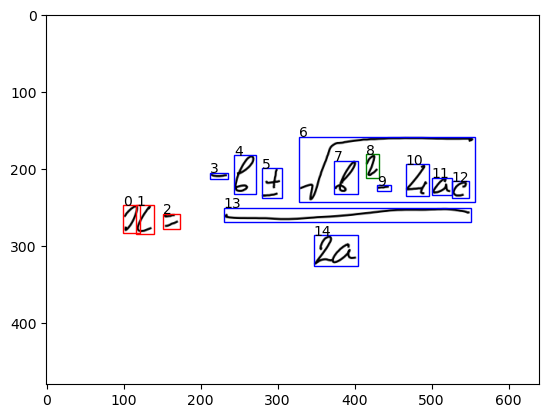

In [2756]:
symbs, levels, script_levels = resolve_symbols_on_img(full_eq_imgs[15])